In [1]:
import random
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
from colorutils import Color

In [2]:
messages = pd.read_csv("texts/message_samples.csv")
options = pd.read_csv("texts/option_samples.csv")
names = pd.read_csv("texts/name_samples.csv")
messages.shape, options.shape, names.shape

((14, 5), (16, 3), (9, 2))

In [3]:
def create_textbox(w, h, hex, alpha=255):
    shape = [(0, 0), (w, h)]
    img = Image.new("RGB", (w, h))
    img1 = ImageDraw.Draw(img)
    img1.rectangle(shape, fill=hex, outline=None)
    img.putalpha(alpha)
    return img

## create textarea

In [99]:
msg_font.getmetrics()

(38, 10)

In [127]:
def get_height(font, c):
    # bbox = font.getbbox(c, anchor="la")  # bbox : left top right bottom
    # return bbox[3]-bbox[1] 
    return font.getmetrics()[0] + font.getmetrics()[1]
    # return font.size

def create_textarea(
    text, w, h, margins,
    font, font_color, character_spacing, line_spacing,
    add_ruby,
    ruby_font, ruby_font_color, ruby_character_spacing, ruby_line_spacing
    ):

    text_img = Image.new(
        "RGBA",
        (w+margins[1]+margins[3], h+margins[0]+margins[2]),  # margins : top right bottom left
        (255, 0, 0, 50)
        )
    text_img_draw = ImageDraw.Draw(text_img)

    x = margins[3]
    y = margins[0]
    if add_ruby:
        y += get_height(ruby_font, "あ") + ruby_line_spacing

    max_height = -1
    in_tag = False
    tag = ""
    ruby_target_x = [-1, -1]
    in_ruby = False
    in_ruby_target = False

    ruby = ""
    ruby_target = ""

    for i, c in enumerate(text):

        if c == "<":  # タグ記述の開始時
            in_tag = True
            tag = text[i:i+text[i:].index(">")+1]

            if in_ruby_target:
                ruby_target_x[1] = x - character_spacing  # ruby対象文字列の終了x
                in_ruby_target = False
            if in_ruby:
                in_ruby = False
                
                # draw ruby
                ruby_target_width = ruby_target_x[1] - ruby_target_x[0]
                ruby_center_x = (ruby_target_x[0] + ruby_target_x[1])/2
                ruby_characters_width = sum([ruby_font.getlength(rc) for rc in ruby])
                ruby_calcled_width =  ruby_characters_width + (ruby_character_spacing * (len(ruby)+1))

                if ruby_target_width > ruby_calcled_width and len(ruby) > 1:
                    # ruby_target_x[0]と[1]の間に均等割り付け
                    _ruby_character_spacing = (ruby_target_width - ruby_characters_width) / (len(ruby)+1)
                    ruby_x = ruby_target_x[0] + _ruby_character_spacing
                else:
                    # ruby_center_x周りにruby_character_spacingで配置
                    ruby_x = ruby_center_x - ruby_calcled_width / 2
                    _ruby_character_spacing = ruby_character_spacing

                if ruby_x < 0:
                    raise ValueError(f"Ruby overflowed from the left of the text area. {ruby_x}")

                # 高さ計算
                ruby_max_height = max([get_height(ruby_font, rc) for rc in ruby])
                ruby_y = y - (ruby_max_height + ruby_line_spacing) 
                
                # ルビを1文字ずつ描画
                for rc in ruby:
                    text_img_draw.text((ruby_x, ruby_y), rc, fill=ruby_font_color, font=ruby_font)
                    ruby_x += ruby_font.getlength(rc) + _ruby_character_spacing
                    if ruby_x - _ruby_character_spacing > w + margins[1]:
                        raise ValueError(f"Ruby overflowed from the right of the text area. {ruby_x - _ruby_character_spacing} > {w + margins[1]}")

                # ルビ情報リセット
                ruby_target_x = [-1, -1]
                ruby = ""
                ruby_target = ""

        # タグ記述<...>の処理
        if in_tag:
            if c == ">":  # タグ記述の終了時
                if tag == "<ruby>":
                    in_ruby_target = True
                    ruby_newline_checked = False
                    ruby_target = text[i+1:i+text[i:].index("<")]
                elif tag == "<rt>":
                    ruby = text[i+1:i+text[i:].index("<")]
                    in_ruby = True
                else:
                    pass
                tag = ""
                in_tag = False
            
            continue  # tag中は描画しない

        if in_ruby:
            continue  # ruby中は描画しない

        # new line
        insert_new_line = False
        if in_ruby_target:
            if not ruby_newline_checked:
                # ルビ対象中は改行しない
                # ルビ終了までの長さを先読みして判定
                insert_new_line = x + sum([font.getlength(_c) + character_spacing for _c in ruby_target]) > w
                ruby_newline_checked = True
        else:
            insert_new_line = x + font.getlength(c) > w
        
        if insert_new_line:
            y += max_height + line_spacing
            if add_ruby:
                y += get_height(ruby_font, "あ") + ruby_line_spacing
            x = margins[3]
            max_height = -1

            if y + get_height(font, c) > h + margins[0] + margins[2]:
                raise ValueError(f"Height was insufficient at new line. {y + get_height(font, c)} > {h + margins[0] + margins[2]}")
        
        # 改行時の行高さをその行の文字の最大高さで計算
        max_height = max(max_height, get_height(font, c)) 
        
        if in_ruby_target and ruby_target_x == [-1, -1]:
            ruby_target_x[0] = x # ruby対象文字列の開始x

        # draw character
        text_img_draw.text((x, y), c, fill=font_color, font=font)#, anchor="lt")

        x += font.getlength(c) + character_spacing
    return text_img

## settings

In [119]:
W, H = 1920, 1080
# fg
fg_tl = (200, 100)

# msgbox
msgbox_tl = (100, 600)
msgbox_br = (1820, 900)
# msgbox_hex = Color(hsv=(180, 1, .5)).hex
msgbox_hex = Color(hsv=(220, .6, .3)).hex
msgbox_alpha = 128

# msg text area
msg_margins = (30, 50, 30, 50)  # top right bottom left
msg_line_spacing = 0
msg_character_spacing = 5
msg_font_size = 32
msg_ruby_font_size = 12
msg_ruby_line_spacing = -5
msg_ruby_character_spacing = 1
msg_font_color = tuple([int(c) for c in Color(hsv=(0, 0, 1)).rgb])
msg_font = ImageFont.truetype(font="./fonts/NotoSansJP-Regular.otf", size=msg_font_size)
msg_ruby_font = ImageFont.truetype(font="./fonts/NotoSansJP-Bold.otf", size=msg_ruby_font_size)

# namebox
namebox_tl = (200, 520)
namebox_br = (600, 698)
namebox_hex = Color(hsv=(220, .6, .3)).hex
namebox_alpha = 180

# name text area
name_margins = (10, 30, 10, 30)  # top right bottom left
name_line_spacing = 0
name_character_spacing = 10
name_font_size = 40
name_ruby_font_size = 16
name_ruby_line_spacing = 0
name_ruby_character_spacing = 0
name_font_color = tuple([int(c) for c in Color(hsv=(0, 0, 1)).rgb])
name_font = ImageFont.truetype(font="./fonts/NotoSansJP-Regular.otf", size=name_font_size)
name_ruby_font = ImageFont.truetype(font="./fonts/NotoSansJP-Bold.otf", size=name_ruby_font_size)

## trial

In [134]:
text = messages.sample(1)["text_ruby_hiragana"].values[0]
name_text, name_ruby = names.sample(1)[["name", "ruby"]].values[0]
if type(name_ruby) == str:
    name_text = f"<ruby>{name_text}<rt>{name_ruby}</rt></ruby>"
text, name_text

('<ruby>血統書<rt>けっとうしょ</rt></ruby>付きの<ruby>子牛<rt>こうし</rt></ruby>は、<ruby>王家<rt>おうけ</rt></ruby>の<ruby>宝<rt>たから</rt></ruby>だからね。大事にされるんだよ?ねっ!?いいかぁ!',
 '<ruby>妹尾 康平<rt>せのお こうへい</rt></ruby>')

In [114]:
# name_text = "ああああああああああああああああああ"
# text = "ほげほげほげほげほげほげおほげほげほげほげ"

<ruby>血統書<rt>けっとうしょ</rt></ruby>付きの<ruby>子牛<rt>こうし</rt></ruby>は、<ruby>王家<rt>おうけ</rt></ruby>の<ruby>宝<rt>たから</rt></ruby>だからね。大事にされるんだよ?ねっ!?いいかぁ!


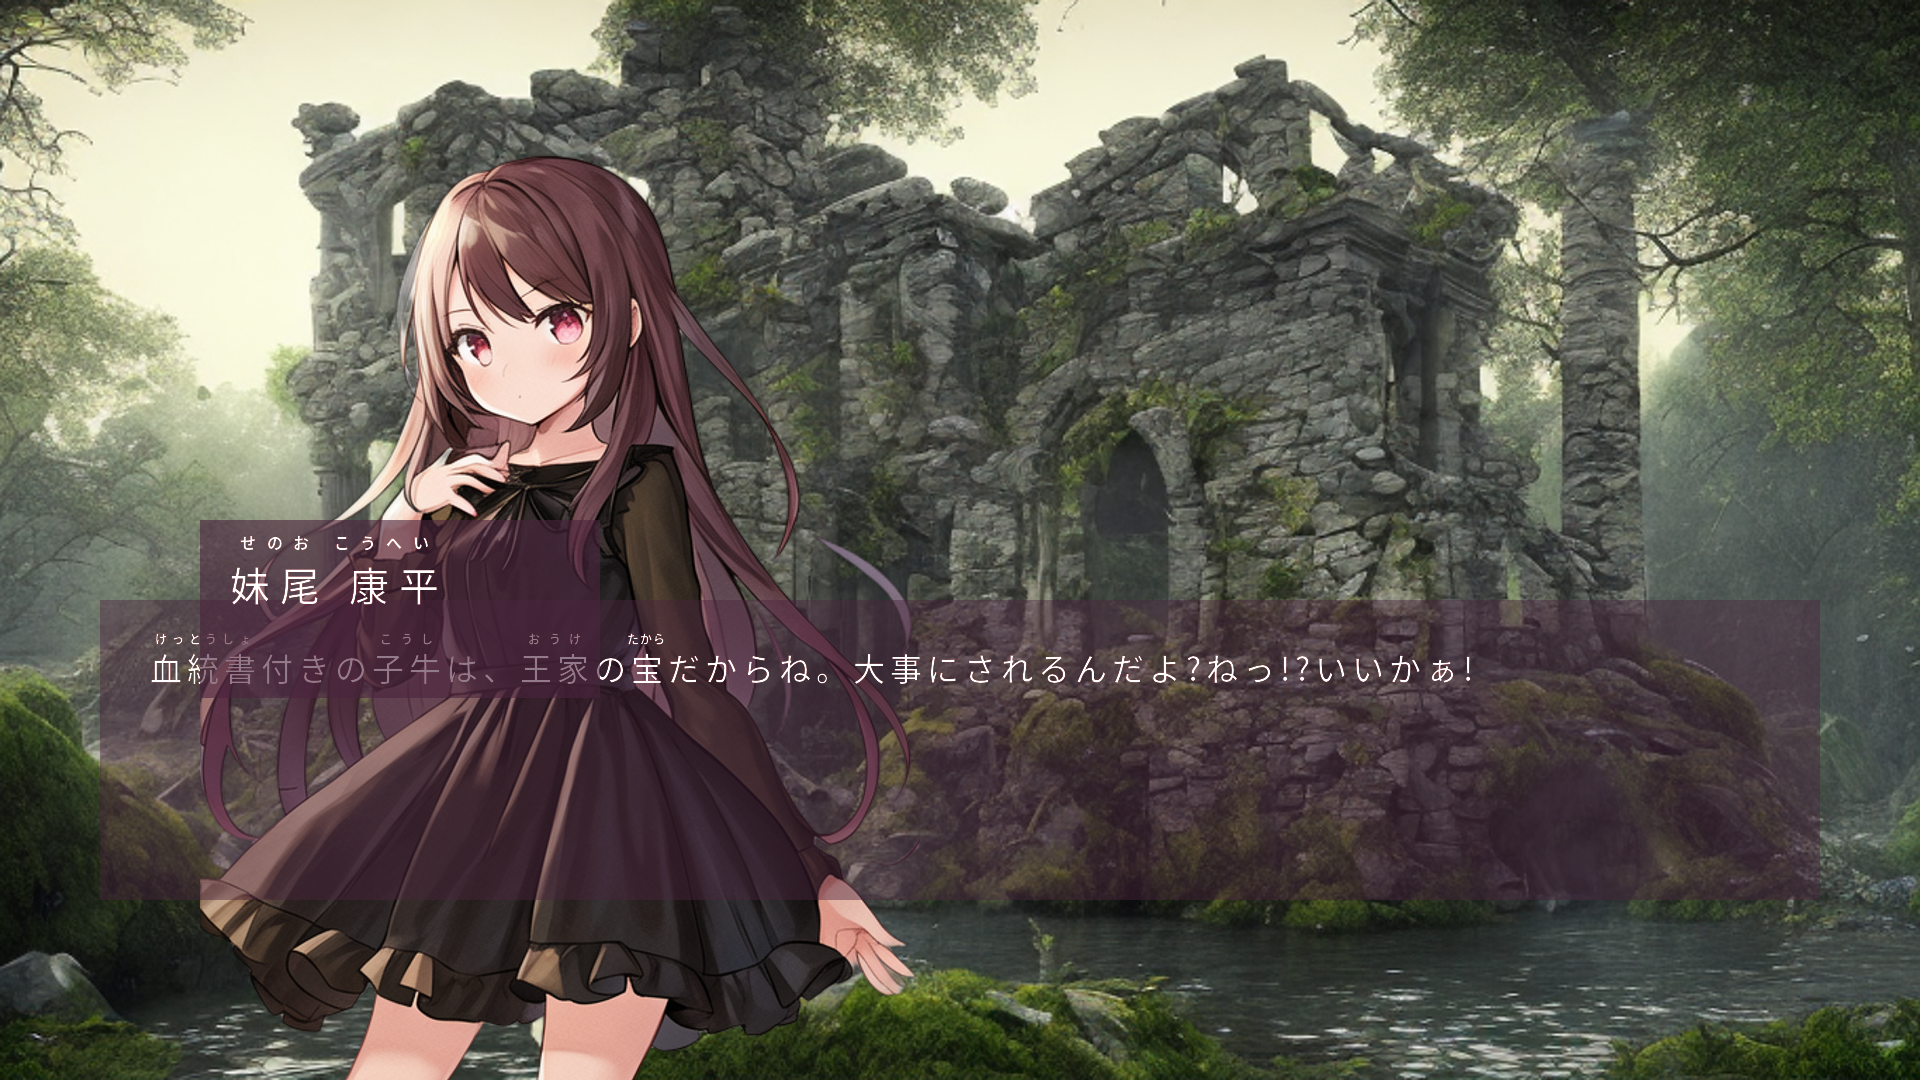

In [135]:
# bg
bg_path = "./bgimages/3.png"
bg = Image.open(bg_path).resize((W, H))

# character
fg_path = "./fgimages/2.png"
fg = Image.open(fg_path)
fg = fg.resize((int(fg.width*(H/fg.height)), H))

# message
msgbox_size = (msgbox_br[0] - msgbox_tl[0], msgbox_br[1] - msgbox_tl[1])
msgbox = create_textbox(
    w=msgbox_size[0],
    h=msgbox_size[1],
    hex=msgbox_hex,
    alpha=msgbox_alpha
    )

print(text)
add_ruby = "<ruby>" in text
try:
    msg_text_img = create_textarea(
        text,
        w=msgbox_size[0]-(msg_margins[1]+msg_margins[3]),
        h=msgbox_size[1]-(msg_margins[0]+msg_margins[2]),
        margins=msg_margins,
        font=msg_font, font_color=msg_font_color,
        character_spacing=msg_character_spacing, line_spacing=msg_line_spacing,
        add_ruby=add_ruby,
        ruby_font=msg_ruby_font, ruby_font_color=msg_font_color,
        ruby_character_spacing=msg_ruby_character_spacing, ruby_line_spacing=msg_ruby_line_spacing
        )
except Exception as e:
    print(e)

msgbox.paste(msg_text_img, (0, 0), msg_text_img)

# name
namebox_size = (namebox_br[0] - namebox_tl[0], namebox_br[1] - namebox_tl[1])
namebox = create_textbox(
    w=namebox_size[0],
    h=namebox_size[1],
    hex=namebox_hex,
    alpha=namebox_alpha
    )

try:
    add_ruby = "<ruby>" in name_text
    name_text_img = create_textarea(
        name_text,
        w=namebox_size[0]-(name_margins[1]+name_margins[3]),
        h=namebox_size[1]-(name_margins[0]+name_margins[2]),
        margins=name_margins,
        font=name_font, font_color=name_font_color,
        character_spacing=name_character_spacing, line_spacing=name_line_spacing,
        add_ruby=add_ruby,
        ruby_font=name_ruby_font, ruby_font_color=name_font_color,
        ruby_character_spacing=name_ruby_character_spacing, ruby_line_spacing=name_ruby_line_spacing
        )
except Exception as e:
    print(e)

namebox.paste(name_text_img, (0, 0), name_text_img)

# paste
img = bg.copy()
img.paste(fg, fg_tl, fg)
img.paste(msgbox, msgbox_tl, msgbox)
img.paste(namebox, namebox_tl, namebox)
img